# TEA and LCA

* **Prepared by:**

    - Yalin Li

* **Covered topics:**

    - Techno-economic analysis (TEA)
        - `TEA` and `SimpleTEA`
    - Life cycle assessment (LCA)
        - `ImpactIndicator`
        - `ImpactItem` and `StreamImpactItem`
        - `Construction`, `Transportation`, and other activities
        - `LCA`

* **Update date:** 2021-04-27
* `qsdsan` **version:** 0.2.6

In [1]:
# To change directory to the cloned qsdsan (as opposed to the pip installed version)
# import os
# path = os.path.realpath('')+'/../../../'
# os.chdir(path)

In [2]:
import biosteam as bst
import qsdsan as qs
from qsdsan import sanunits as su
from exposan import bwaise as bw

## Techno-economic analysis (TEA)
TEA in `qsdsan` is performed through the `TEA` object in `biosteam`, but a new `SimpleTEA` class (subclass of `TEA`) is added for simpler systems that are more relevant for sanitation-related studies.

For use of `TEA`, follow the [tutorial](https://biosteam.readthedocs.io/en/latest/tutorial/Techno-economic_analysis.html) provided in `biosteam` documents.

### Features of `SimpleTEA`
Here we will focus on some features of `SimpleTEA`.

System: sys1
ins...
[0] U2_toilet_paper
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Tissue  0.000282
[1] U2_flushing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): H2O  0.0231
[2] U2_cleansing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[3] U2_desiccant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] U2_excreta
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): NH3      2.78e-05
                    NonNH3   3.72e-05
                    P        9.02e-06
                    K        1.51e-05
                    Mg       6.17e-06
                    Ca       1.81e-05
                    H2O      0.0124
                    ...
[1] U2_leachate
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): NH3  1.74e-05
                    P    1.98e-06
                    K    4.03e-06
                    H2O  0.0448
[2] U2_fugative_CH4
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): CH4  4.31e

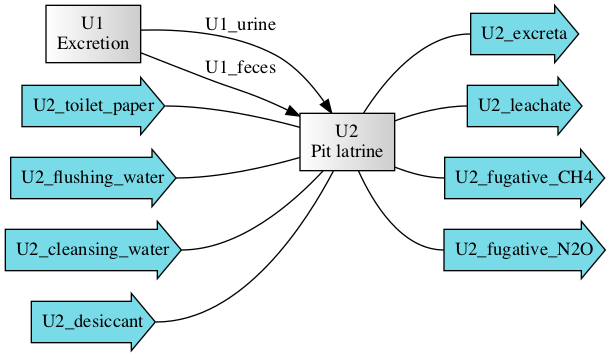

In [3]:
# First we need to construct a system, let's assume we want to look at a pit latrine
cmps = bw.cmps
bst.settings.set_thermo(cmps)
U1 = su.Excretion('U1', outs=('U1_urine', 'U1_feces'))
U2 = su.PitLatrine('U2', ins=(U1-0, U1-1, 'U2_toilet_paper', 'U2_flushing_water',
                              'U2_cleansing_water', 'U2_desiccant'),
                   outs=('U2_excreta', 'U2_leachate', 'U2_fugative_CH4', 'U2_fugative_N2O'),
                   N_user=4, N_toilet=2,
                  decay_k_COD=3, decay_k_N=3, max_CH4_emission=0.25)
sys1 = bst.System('sys1', path=(U1, U2))
sys1.simulate()
sys1.show()
sys1.diagram('thorough')

In [4]:
#  There is no costs associated with the Excretion unit
U1.results()

,Excretion,Units,U1
Total purchase cost,,USD,0
Utility cost,,USD/hr,0


In [5]:
# But the PitLatrine unit has capital and operating costs
U2.results()

Pit latrine                                      Units       U2
Design              Number of users per toilet                4
                    Parallel toilets                          2
                    Emptying period                 yr      0.8
                    Single pit volume               m3     3.66
                    Single pit area                 m2      0.8
                    Single pit depth                       4.57
                    Cement                          kg  1.4e+03
                    Sand                            kg 6.34e+03
                    Gravel                          kg 2.56e+03
                    Brick                           kg      454
                    Plastic                         kg     20.2
                    Steel                           kg     67.2
                    Wood                            m3     0.38
                    Excavation                      m3     7.31
Purchase cost       Total toilets                  USD      898
Total purchase cost                                USD      898
Utility cost                                    USD/hr        0
Additional OPEX                                 USD/hr  0.00513

In [6]:
# Note that all SanUnit has a add_OPEX attribute where you can specify the OPEX cost per hr
# in addition to materials and utilities.
U2.add_OPEX

{'Additional OPEX': 0.0051255707762557084}

In [7]:
# With some assumptions, we can calculate costs associated with this system like
tea1 = qs.SimpleTEA(system=sys1, discount_rate=0.05, lifetime=10)
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 USD at 5.0% discount rate
EAC  : 184 USD/yr
CAPEX: 898 USD (annualized to 139 USD/yr)
AOC  : 45 USD/yr


In [8]:
# Or you directly access the net present value (NPV), equivalent annual cost (EAC),
# capital expenditure (CAPEX, or total capital cost), and annual operating cost (AOC)
tea1.EAC

183.8401886376576

In [9]:
# Currency depends on the setting of qsdsan
tea1.currency == qs.currency

True

In [10]:
# The following will return an error
# tea1.currency = 'euro'

In [11]:
qs.currency = 'euro'
tea1.show()

SimpleTEA: sys1
NPV  : -1,245 euro at 5.0% discount rate
EAC  : 184 euro/yr
CAPEX: 898 euro (annualized to 139 euro/yr)
AOC  : 45 euro/yr


## Life cycle assessment (LCA)
### `ImpactIndicator`
To do LCA, you first need to specify `ImpactIndicator` objects you want to use.

In [12]:
# Assume we are mostly interested in global warming potential and fossil energy consumption.
GWP = qs.ImpactIndicator('GlobalWarming', method='TRACI', category='environmental impact', unit='kg CO2-eq',
                         description='Effect of climate change measured as global warming potential.')
FEC = qs.ImpactIndicator('FossilEnergyConsumption', alias='FEC', unit='MJ')

/Users/yalinli_cabbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: <ImpactIndicator: GlobalWarming> has been replaced in registry
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
GWP.show()

ImpactIndicator: GlobalWarming as kg CO2-eq
 Alias      : None
 Method     : TRACI
 Category   : environmental impact
 Description: Effect of climate change ...


In [14]:
# You can set alias for indicators (you can also set it during initiation as in the example above for FEC)
GWP.alias = 'GWP'
GWP.show()

ImpactIndicator: GlobalWarming as kg CO2-eq
 Alias      : GWP
 Method     : TRACI
 Category   : environmental impact
 Description: Effect of climate change ...


### `ImpactItem` and `StreamImpactItem`
Once you have impact indicators, you can start adding impact items and specify the relative impact each item with the quantity of one functional unit has for the different indicators.

#### `ImpactItem`
For example, assume we need some electricity, and that to generate 1 kWh of electricity, 0.15 kg of CO<sub>2</sub> is emitted, and it uses 4500 kJ of fossil energy.

In [15]:
electricity = qs.ImpactItem('electricity', functional_unit='kWh')

In [16]:
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
 None


In [17]:
# We can add characterization factors (CFs) for the two impact indicators GWP and FEC
electricity.add_indicator(GWP, 0.25)
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      0.25


In [18]:
# If you provide unit when adding the CF value, qsdsan will do the unit conversion
electricity.add_indicator(FEC, 4500, 'kJ')
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                       4.5


In [19]:
# If you later want to change this value, you can also do it
electricity.CFs['FossilEnergyConsumption'] = 50
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                        50


In [20]:
# You can also provide the price for the item
electricity.price = 0.1
electricity.show()

ImpactItem      : electricity [per kWh]
Price           : 0.1 USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                         0.25
FossilEnergyConsumption (MJ)                        50


**Note:** The price is mainly used for construction and transportation items and will be included in unit CAPEX, if you want to add account for the cost of electricity, you should set the power utility usage of the unit and modify `biosteam.PowerUtility.price`.

#### `StreamImpactItem`
A special case of impact items are ones related to material inputs and generated wastes/emissions, where it's more convenient to use `StreamImpactItem` (a subclass of `ImpactItem`).

In [21]:
urine_item = qs.StreamImpactItem(linked_stream=U2-0, GWP=1)
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : U2_excreta
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                         1


In [22]:
# For example, let's assume we want to account for the emissions with the waste stream of U2
# Note that indicator CFs can also be added via kwargs
urine_item = qs.StreamImpactItem(linked_stream=U2-0, GWP=1, FEC=(1, 'MJ'))
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : U2_excreta
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                         1


In [23]:
# The price of this urine_item will be linked to the price of the stream
urine = U2.outs[0]
urine.price = 0.2
urine_item.show()

StreamImpactItem: [per kg]
Linked to       : U2_excreta
Price           : 0.2 USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                         1


In [24]:
# In designing the system, you may need multiple items of the same settings,
# for example you can have many urine streams, then you can link them to a same source
urine2 = qs.WasteStream('urine2', Water=100)
urine_item2 = urine_item.copy(stream=urine2, set_as_source=True)
urine_item2.show()

StreamImpactItem: [per kg]
Linked to       : urine2
Source          : U2_excreta_item
Price           : None USD
ImpactIndicators:
                              Characterization factors
GlobalWarming (kg CO2-eq)                            1
FossilEnergyConsumption (MJ)                         1


In [25]:
# This works for ImpactItem objects other than StreamImpactItem as well
Cement2 = U2.construction[0].item.copy(new_ID='copied_cement', set_as_source=True)
Cement2.show()

ImpactItem      : copied_cement [per kg]
Source          : Cement
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      1.08


### `Construction`, `Transportation`, and other activities
With these defined impact items, we can now account for impacts with construction, transportation, and other activities during LCA.

#### `Construction`
The `Construction` class is used to include impacts associated with the construction of a certain unit and is stored in the `SanUnit.construction`.

In [26]:
# For example, the pit latrine has several construction activities
U2.construction

(<Construction: Constr141>,
 <Construction: Constr142>,
 <Construction: Constr143>,
 <Construction: Constr144>,
 <Construction: Constr145>,
 <Construction: Constr146>,
 <Construction: Constr147>,
 <Construction: Constr148>)

In [27]:
Cement = U2.construction[0]
Cement.show()

Construction : Cement
Lifetime     : None yr
Quantity     : 1400 kg
Total cost   : None USD
Total impacts:
                           Impacts
GlobalWarming (kg CO2-eq) 1.51e+03


In [28]:
# Each Construction activity is linked with an ImpactItem
Cement.item.show()

ImpactItem      : Cement [per kg]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                      1.08


In [29]:
# The total impact and cost is calculated through the quantity of the activity
# and the price/CFs of the its impact item
Cement.quantity

1400.0

In [30]:
Cement.impacts['GlobalWarming'] == Cement.item.CFs['GlobalWarming']*Cement.quantity

True

#### `Transportation`
Similar to `Construction`, each `Transportation` object is linked to an `ImpactItem`, but it calculates the total impacts by taking into the transportation load, distance, and interval.

In [31]:
# For example, suppose we want to take calculate impacts associated with cars
# First to make an ImpactItem for this
car_item = qs.ImpactItem('car_item', functional_unit='kg*km', GWP=10)
car_item.show()

ImpactItem      : car_item [per kg*km]
Price           : None USD
ImpactIndicators:
                           Characterization factors
GlobalWarming (kg CO2-eq)                        10


In [32]:
# Then to add the Transportation activity
# I'm using a weird unit for fun
car_trans = qs.Transportation(item='car_item', load_type='mass', load=5000, load_unit='kg',
                             distance=5e6, distance_unit='cm', interval=20)
car_trans.show()

Transportation: car_item [per trip]
Load          : 5000 kg
Distance      : 50.0 km
Interval      : 20 hr
Total cost    : None USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq)  2.5e+06


**Note:** Here the imapcts are calculated for each trip, in LCA, `qsdsan` will calculate how many trips are made in the entire lifetime of the system using `interval`.

In [33]:
# Transportation activities are stored in ``SanUnit.transportation``
bw.A3.transportation

(<Transportation: Trans22>,)

In [34]:
Trucking = bw.A3.transportation[0]
Trucking.show()

Transportation: item18 [per trip]
Load          : 9.86E+07 kg
Distance      : 5 km
Interval      : 7008 hr
Total cost    : None USD
Total impacts :
                           Impacts
GlobalWarming (kg CO2-eq) 9.57e+04


#### Other activities
If there are additional activities that are not covered by materials, construction, and transportation (e.g., electricity), you can add it when making the `LCA` object (example below).

### `LCA`
Finally, we can make the actual `LCA` object. Like `TEA` objects, each `LCA` object is linked with a `System` object. For illustration purpose, let's just use a pre-defined system (Scenario A in [Trimmer et al.](https://doi.org/10.1021/acs.est.0c03296)).

System: sysA
ins...
[0] toilet_paper
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Tissue  0.000282
[1] flushing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): H2O  0.0231
[2] cleansing_water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[3] desiccant
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] A_CH4
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): CH4  4.37
[1] A_N2O
    phase: 'g', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): N2O  0.000967
[2] A_sol_N
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): NonNH3  0.13
[3] A_sol_P
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): P  0.0984
[4] A_sol_K
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): K  0.11
[5] A_sol_non_fertilizers
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Mg       0.0967
                    Ca       0.446
                    H2O      46.3
                    OtherSS  263
[6] A_liq_N
  

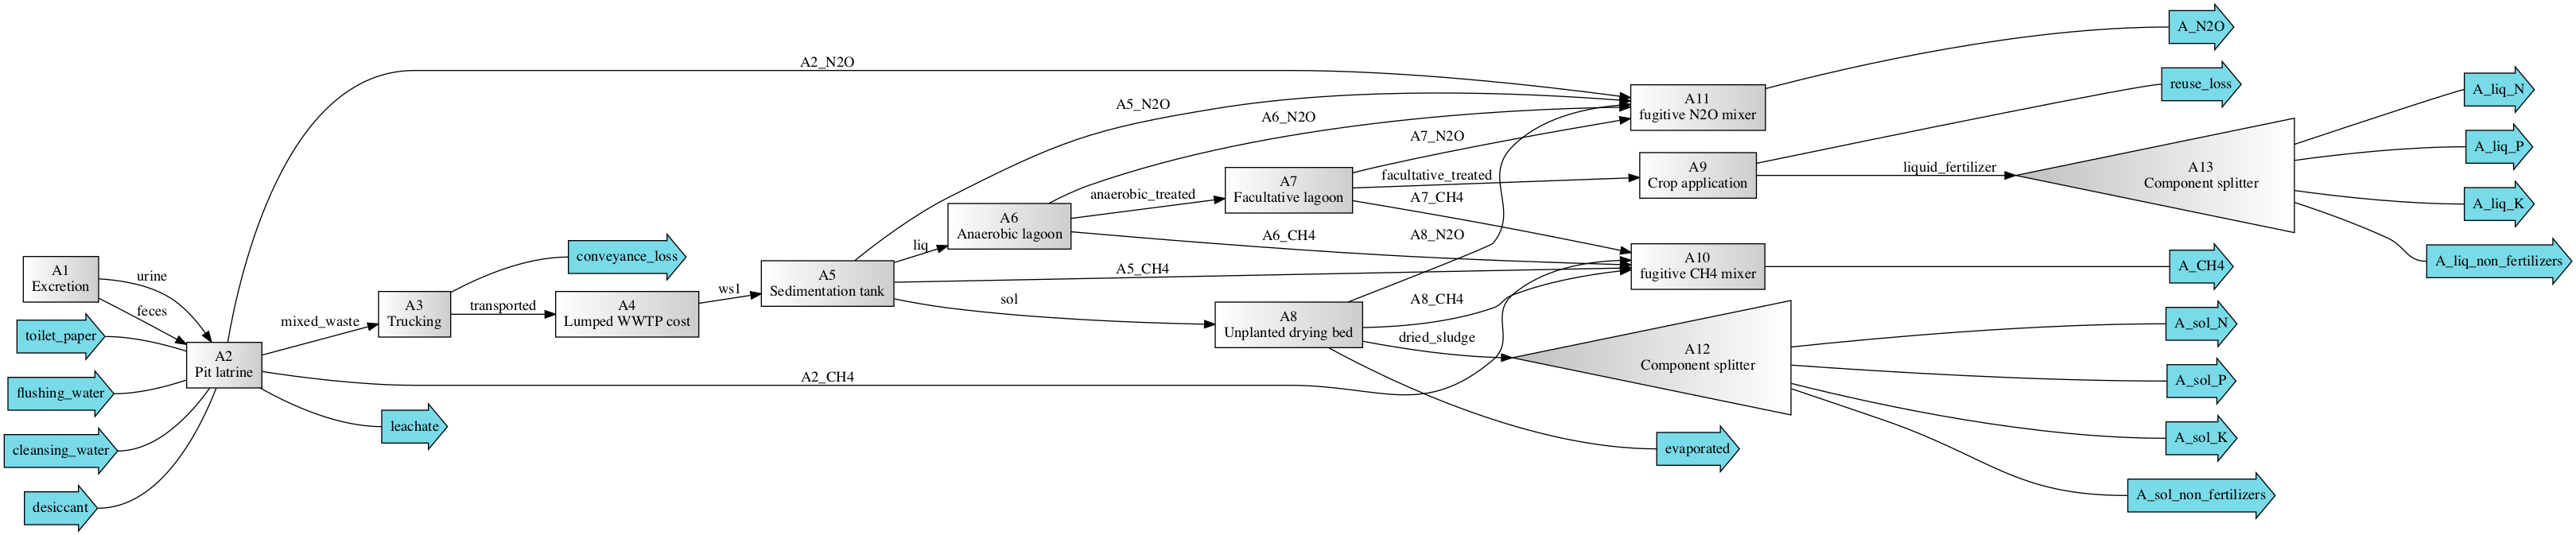

In [35]:
sys = bw.sysA
sys.show()
# You can double-click the diagram to enlarge it
sys.diagram('thorough')

In [36]:
# Note that here electricity is the additional impact activity that is not covered by
# construction, transportation, or material inputs/waste emissions
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr')

In [37]:
# Note that you can add impact activities not included in unit design and streams,
# in this case it's the electricity
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=1e6)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                              Construction  Transportation  WasteStream  Others    Total
GlobalWarming (kg CO2-eq)         3.13e+07        9.57e+05     1.14e+08 2.5e+05 1.47e+08
FossilEnergyConsumption (MJ)             0               0            0   5e+07    5e+07


In [38]:
# If impacts from those other activities change with simulation,
# you can add them as functions
import numpy as np
lca = qs.LCA(system=sys, lifetime=8, lifetime_unit='yr', electricity=np.random.rand)
lca.show()

LCA: sysA (lifetime 8 yr)
Impacts:
                              Construction  Transportation  WasteStream  Others    Total
GlobalWarming (kg CO2-eq)         3.13e+07        9.57e+05     1.14e+08 0.00213 1.46e+08
FossilEnergyConsumption (MJ)             0               0            0   0.426     36.2


In [39]:
# We can also get a more detailed break-down for a specific category
# Note that we need to redefine lca as the electricity 
lca.get_impact_table('Construction')

Quantity Item Ratio GlobalWarming [kg CO2-eq]  \
Construction    SanUnit                                                 
Brick [kg]      A2      6.47e+06          1                  1.81e+06   
                Total   6.47e+06          1                  1.81e+06   
Cement [kg]     A2         2e+07          1                  2.16e+07   
                Total      2e+07          1                  2.16e+07   
Concrete [m3]   A5           433     0.0667                   1.3e+05   
                A8      6.06e+03      0.933                  1.82e+06   
                Total   6.49e+03          1                  1.95e+06   
Excavation [m3] A2      1.04e+05      0.731                  5.53e+04   
                A5      1.45e+03     0.0102                       769   
                A6      1.39e+04     0.0975                  7.38e+03   
                A7      2.31e+04      0.162                  1.22e+04   
                Total   1.43e+05          1                  7.57e+04   
Gravel [kg]     A2      3.65e+07          1                  5.48e+05   
                Total   3.65e+07          1                  5.48e+05   
Plastic [kg]    A2      2.88e+05      0.947                  5.67e+05   
                A6      4.54e+03     0.0149                  8.94e+03   
                A7      1.15e+04     0.0377                  2.26e+04   
                Total   3.04e+05          1                  5.98e+05   
Sand [kg]       A2      9.05e+07          1                  1.09e+06   
                Total   9.05e+07          1                  1.09e+06   
Steel [kg]      A2      9.58e+05      0.933                  2.44e+06   
                A8      6.93e+04     0.0674                  1.77e+05   
                Total   1.03e+06          1                  2.62e+06   
Wood [m3]       A2      5.42e+03          1                  1.07e+06   
                Total   5.42e+03          1                  1.07e+06   
Sum             All                                          3.13e+07   

                        Category GlobalWarming Ratio  \
Construction    SanUnit                                
Brick [kg]      A2                            0.0578   
                Total                         0.0578   
Cement [kg]     A2                             0.689   
                Total                          0.689   
Concrete [m3]   A5                           0.00415   
                A8                             0.058   
                Total                         0.0621   
Excavation [m3] A2                           0.00176   
                A5                          2.45e-05   
                A6                          0.000235   
                A7                           0.00039   
                Total                        0.00242   
Gravel [kg]     A2                            0.0175   
                Total                         0.0175   
Plastic [kg]    A2                            0.0181   
                A6                          0.000285   
                A7                          0.000721   
                Total                         0.0191   
Sand [kg]       A2                            0.0347   
                Total                         0.0347   
Steel [kg]      A2                             0.078   
                A8                           0.00564   
                Total                         0.0836   
Wood [m3]       A2                            0.0341   
                Total                         0.0341   
Sum             All                                1   

                        FossilEnergyConsumption [MJ]  \
Construction    SanUnit                                
Brick [kg]      A2                                 0   
                Total                              0   
Cement [kg]     A2                                 0   
                Total                              0   
Concrete [m3]   A5                                 0   
                A8

In [40]:
lca.get_impact_table('Stream')

,Mass [kg],GlobalWarming [kg CO2-eq],Category GlobalWarming Ratio,FossilEnergyConsumption [MJ],Category FossilEnergyConsumption Ratio
Stream,,,,,
A_CH4,4.91e+06,1.38e+08,1.21,0,0
A_N2O,2.98e+03,7.9e+05,0.00693,0,0
A_liq_K,1.98e+06,-2.97e+06,-0.026,0,0
A_liq_N,3.23e+06,-1.74e+07,-0.153,0,0
A_liq_P,3.46e+05,-1.69e+06,-0.0149,0,0
A_sol_K,3.02e+05,-4.53e+05,-0.00397,0,0
A_sol_N,1.28e+05,-6.91e+05,-0.00606,0,0
A_sol_P,2.14e+05,-1.05e+06,-0.00918,0,0
Sum,,1.14e+08,1,0,1


In [41]:
# For streams, you can specify kind to be 'all', 'direct_emission', or 'offset'
lca.get_stream_impacts(stream_items=lca.stream_inventory)

{'GlobalWarming': 114026446.18089803, 'FossilEnergyConsumption': 0.0}

In [42]:
# You can also normalize the impacts to a certain stream
liq_N = bw.A13.outs[0]
lca.get_allocated_impacts(liq_N, allocate_by='energy')

{'GlobalWarming': 163755921.95841864,
 'FossilEnergyConsumption': 27.504647045498043}

In [43]:
# You can also look at all impacts associtated with a certain unit
lca.get_unit_impacts(bw.A2)

{'GlobalWarming': 111628208.84432897,
 'FossilEnergyConsumption': 1.238839057958463}

In [44]:
# Finally, you can export all the details as an Excel file
lca.save_report('lca.xlsx')